## Cargamos las librerias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import time

## Cargamos el dataset de tweets y vemos su informacion

In [2]:
df_tweets = pd.read_csv("dataset_Caso_2.csv")
print(df_tweets.shape)
df_tweets.head()

(2649, 1)


,texto_tweet
0,¡Atención! @ElMercurio_cl y @CajaLosAndes dest...
1,@CajaLosAndes el dia 9 de abril fui a @Cinepo...
2,"@CajaLosAndes Hola, Les envié DM para que me p..."
3,"@CajaLosAndes hola, necesito saber en que tram..."
4,Convenio DIVBIE - Caja Los Andes\n\nPara el pe...


In [3]:
df_tweets.isnull().sum()

texto_tweet    0
dtype: int64

## Cargamos el modelo pre-entrenado y el tokenizador

### El modelo a utlizar será una versión multi lenguaje de bert, obtenido desde hugging face:
* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [4]:
nombre_modelo = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(nombre_modelo)
modelo = AutoModelForSequenceClassification.from_pretrained(nombre_modelo)

## Ahora armaremos algunas funciones que nos permitan limpiar el tweet antes de obtener el sentimiento

In [35]:
def reemplazar_saltos_de_linea(texto):
    return texto.replace('\n', ' ')

In [5]:
entidades = ['@IPSChile','@MintrabChile','@GobiernodeChile','@MinDesarrollo','@previsionsocial',
                 '@subse_ssociales','@SENAMAGOB','@IPSValparaiso','@MDSValparaiso','@ChileAtiende','@IPSChile',
            '@RegCivil_Chile','@GobDigitalCL']

def mencion_gobierno(texto):
    for entidad in entidades:
        if entidad.lower() in texto.lower():
            return "Si"
    return "No"

In [31]:
def quitar_menciones(words):
    palabras = []
    for word in words:
        if ((word.startswith('@')) & (len(word) > 1)):
            palabra = ''
        elif word.startswith('http'):
            palabra = ''
        elif word == 'rt':
            palabra = ''
        else:
            palabra = word
        palabras.append(palabra)
        texto = ' '.join(palabras)
    return texto

In [32]:
def obtener_sentimiento(df):
    inputs = tokenizer(df, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = modelo(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(probs).item()
    
    # Mapeo de los resultados a sentimiento (0: muy negativo, 4: muy positivo)
    sentiment_map = {0: 'Muy negativo', 1: 'Negativo', 2: 'Neutral', 3: 'Positivo', 4: 'Muy positivo'}
    return sentiment_map[sentiment]

In [46]:
# Procesamos el texto y luego obtenemos las menciones al SERNAC y el sentimiento del tweet
start_time = time.time()

df_tweets["texto_procesado"] = df_tweets["texto_tweet"].astype(str).str.lower()
df_tweets["texto_procesado"] = df_tweets["texto_procesado"].apply(reemplazar_saltos_de_linea)
df_tweets["texto_procesado"] = df_tweets["texto_procesado"].str.split(' ')
df_tweets["Mencion_Gobierno"] = df_tweets["texto_tweet"].apply(mencion_gobierno)
df_tweets["texto_procesado"] = df_tweets['texto_procesado'].apply(quitar_menciones)
df_tweets['Sentimiento'] = df_tweets['texto_procesado'].apply(obtener_sentimiento)

print("--- Procesamiento del texto: %s seconds ---" % (time.time() - start_time))

--- Procesamiento del texto: 284.260427236557 seconds ---


In [47]:
df_tweets.head(20)

,texto_tweet,texto_procesado,Mencion_Gobierno,Sentimiento
0,¡Atención! @ElMercurio_cl y @CajaLosAndes dest...,¡atención! y destacaron a #congresofuturo co...,No,Muy positivo
1,@CajaLosAndes el dia 9 de abril fui a @Cinepo...,el dia 9 de abril fui a y no me aceptaron e...,No,Muy negativo
2,"@CajaLosAndes Hola, Les envié DM para que me p...","hola, les envié dm para que me puedan ayudar ...",No,Neutral
3,"@CajaLosAndes hola, necesito saber en que tram...","hola, necesito saber en que tramo de carga fa...",No,Neutral
4,Convenio DIVBIE - Caja Los Andes\n\nPara el pe...,convenio divbie - caja los andes para el pers...,No,Positivo
5,RT @IgualesChile: 🏅Fuimos reconocid@s por @ElM...,🏅fuimos reconocid@s por y en el especial d...,No,Muy positivo
6,"@CajaLosAndes Buen día, les escribo porque nue...","buen día, les escribo porque nuevamente no lo...",No,Muy positivo
7,"@CajaLosAndes por ley y cito "" D.F.L. N° 44, c...","por ley y cito "" d.f.l. n° 44, citado en fuen...",No,Muy negativo
8,"Hola a todos!, espero que estén teniendo una b...","hola a todos!, espero que estén teniendo una b...",No,Muy positivo
9,"@CajaLosAndes Hola, envié un DM, ¿me pueden ay...","hola, envié un dm, ¿me pueden ayudar?",No,Muy positivo


## Ahora haremos algunos análisis respecto al sentimiento y las meciones de los usuarios

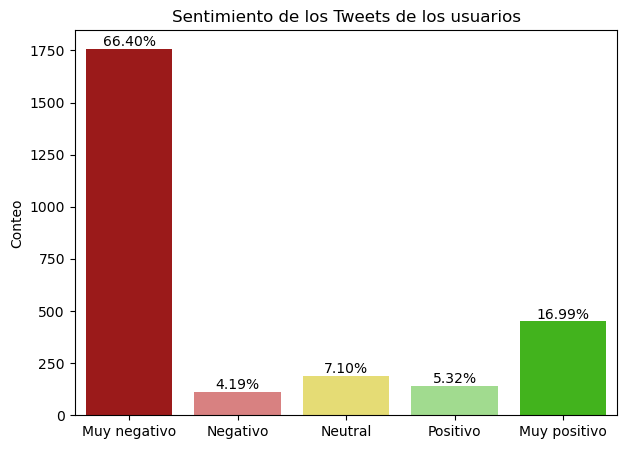

In [48]:
# Establecemos el orden de las columnas
order = ['Muy negativo', 'Negativo', 'Neutral', 'Positivo', 'Muy positivo']

# Definir colores específicos para cada categoría
colors = ['#b00505', '#e67373', '#f7eb63', '#9be882', '#36cc04']

# Crear el gráfico de histograma
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=df_tweets, x='Sentimiento', order=order, palette=colors)

# Obtener los valores de las barras
total = len(df_tweets)  # Total de datos
for patch in ax.patches:
    height = patch.get_height()  # Altura de cada barra (conteo)
    percentage = 100 * height / total  # Calcular el porcentaje
    ax.text(patch.get_x() + patch.get_width() / 2, height, f'{percentage:.2f}%', 
            ha='center', va='bottom')  # Etiqueta con el porcentaje

# Personalizar gráfico
plt.ylabel('Conteo')
plt.xlabel('')
plt.title('Sentimiento de los Tweets de los usuarios')

plt.show()

### Vemos que alrededor del 70% de los tweets corresponden a comentarios negativos sobre la empresa, mientras que un 22% de los tweets tienen una connotación positiva.

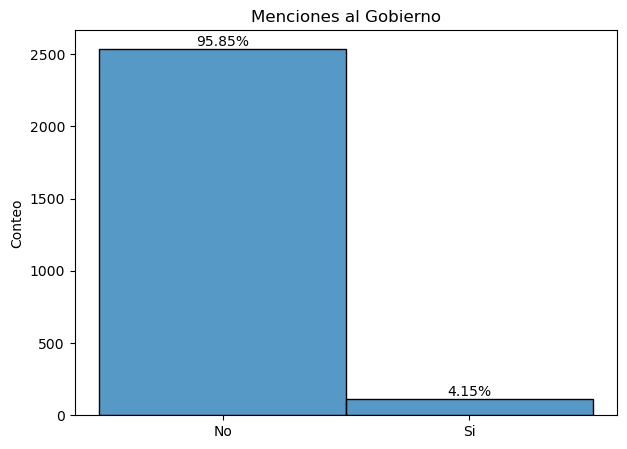

In [49]:
# Crear el gráfico de histograma
plt.figure(figsize=(7, 5))
ax = sns.histplot(data=df_tweets, x='Mencion_Gobierno')

# Obtener los valores de las barras
total = len(df_tweets)  # Total de datos
for patch in ax.patches:
    height = patch.get_height()  # Altura de cada barra (conteo)
    percentage = 100 * height / total  # Calcular el porcentaje
    ax.text(patch.get_x() + patch.get_width() / 2, height, f'{percentage:.2f}%', 
            ha='center', va='bottom')  # Etiqueta con el porcentaje

# Personalizar gráfico
plt.xlabel('')
plt.ylabel('Conteo')
plt.title('Menciones al Gobierno')

plt.show()

### Por otro lado, los usuarios mencionan a entidades del gobierno un 4,15% de las veces

# Guardamos el archivo con los resultados

In [50]:
df_tweets.to_csv('data_caso_2_con_sentimiento.csv', index=False)